In [1]:
import os 
import cv2
import numpy as np
from tqdm import tqdm

import torch
import torch.utils as utils
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"# Using device: {device}")

# Using device: cuda


In [3]:
torch.cuda.empty_cache()

In [11]:
class dehazer(): 

    def __init__(self, IMG_SIZE, LABEL_DIR, LABEL_NAME):
        self.IMG_SIZE = IMG_SIZE
        self.LABEL_DIR = LABEL_DIR
        self.LABEL_NAME = LABEL_NAME
        self.training_data = []

    def make_training_data(self):
        NUM_IMAGES = len(os.listdir(self.LABEL_DIR))
        for i in tqdm(range(1, NUM_IMAGES+1)):
            f = f"{str(i).zfill(2)}_indoor_{self.LABEL_NAME}.jpg"  # Adjusted file name format
            path = os.path.join(self.LABEL_DIR, f)
            if not os.path.exists(path):
                print(f"Image file at {path} does not exist.")
                continue
            img = cv2.imread(path)
            if img is None:
                print(f"Image at {path} could not be loaded.")
                continue
            img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
            self.training_data.append(np.array(img))
        np.save(f'{self.LABEL_NAME}.npy', self.training_data)

In [12]:
REBUILD_DATA=True
try:     
    IMG_SIZE=256
    gt_dir='../minor_project/input/GT' 
    hazy_dir='../minor_project/input/hazy' 
    
except Exception as e:
    print(str(e))
    
if (REBUILD_DATA):
    dehazing=dehazer(IMG_SIZE, gt_dir, 'GT')
    dehazing.make_training_data()
    
    dehazing=dehazer(IMG_SIZE, hazy_dir, 'hazy')
    dehazing.make_training_data()

100%|██████████| 30/30 [00:06<00:00,  4.78it/s]


Image file at ../minor_project/input/GT/26_indoor_GT.jpg does not exist.
Image file at ../minor_project/input/GT/27_indoor_GT.jpg does not exist.
Image file at ../minor_project/input/GT/28_indoor_GT.jpg does not exist.
Image file at ../minor_project/input/GT/29_indoor_GT.jpg does not exist.
Image file at ../minor_project/input/GT/30_indoor_GT.jpg does not exist.


100%|██████████| 30/30 [00:06<00:00,  5.00it/s]

Image file at ../minor_project/input/hazy/26_indoor_hazy.jpg does not exist.
Image file at ../minor_project/input/hazy/27_indoor_hazy.jpg does not exist.
Image file at ../minor_project/input/hazy/28_indoor_hazy.jpg does not exist.
Image file at ../minor_project/input/hazy/29_indoor_hazy.jpg does not exist.
Image file at ../minor_project/input/hazy/30_indoor_hazy.jpg does not exist.


In [13]:
patch = np.load('GT.npy',allow_pickle=True)
mask = np.load('hazy.npy',allow_pickle=True)

len(patch), len(mask)

(25, 25)

In [14]:
patch.shape, mask.shape

((25, 256, 256, 3), (25, 256, 256, 3))

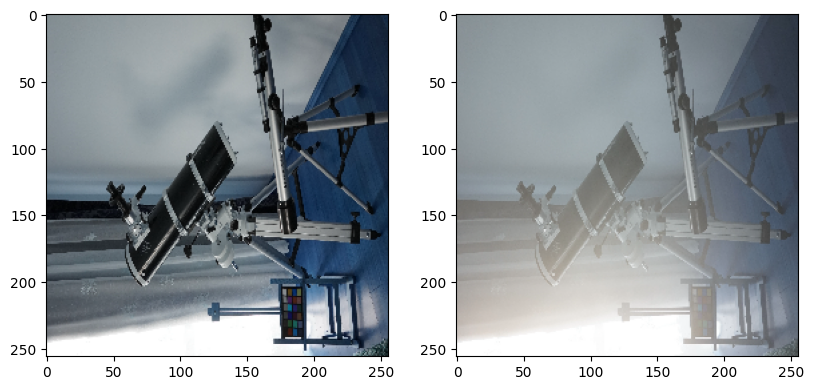

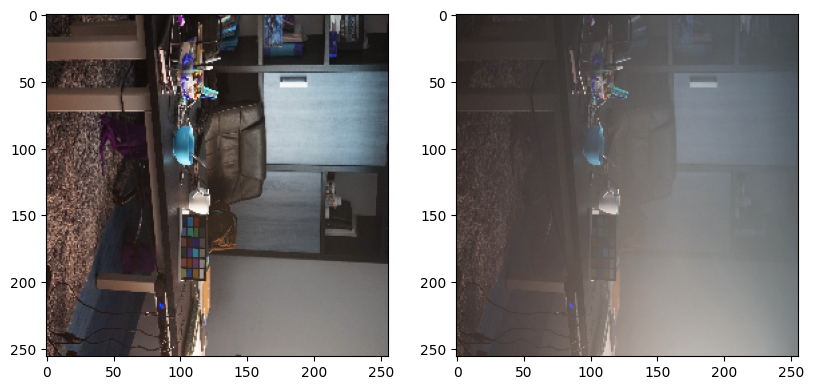

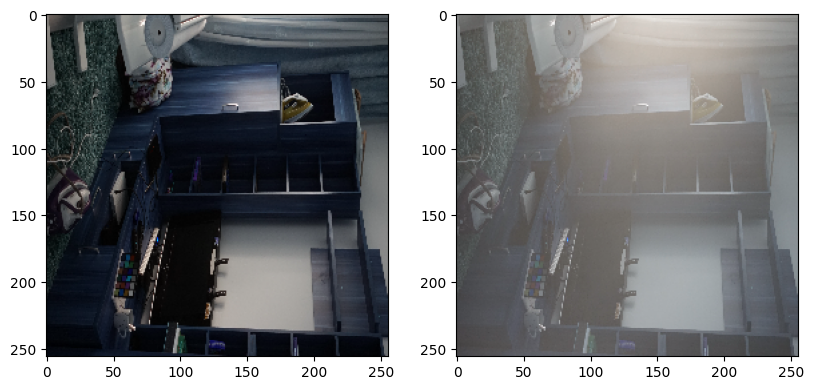

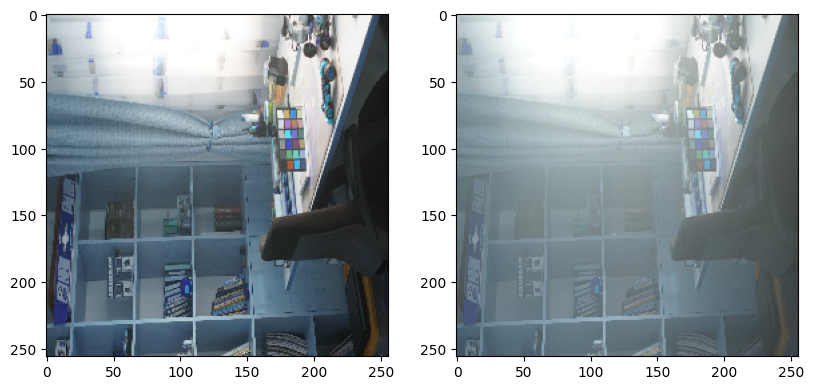

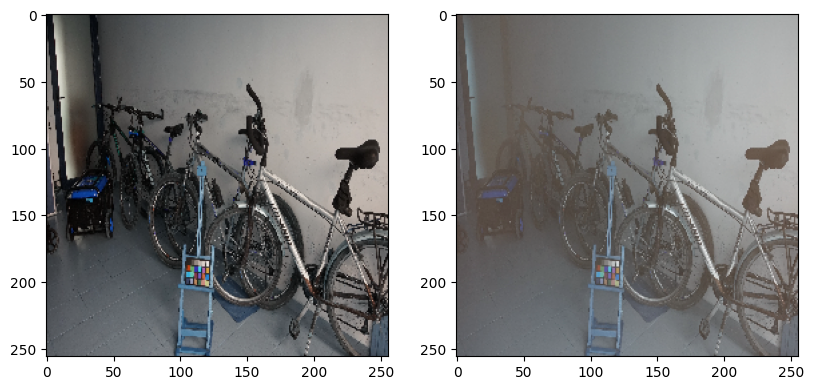

In [15]:
for i in range(0,len(patch),5):
    
    fig=plt.figure(figsize=(15, 5))
    
    ax = plt.subplot(131)
    plt.imshow(patch[i])
    
    ax = plt.subplot(132)
    plt.imshow(mask[i])
    plt.show()

In [16]:
IMG_SIZE = 256

EPOCHS = 1000
batch_size = 1
learning_rate = 0.0005

In [17]:


patch_loader = torch.utils.data.DataLoader(dataset=patch,batch_size=batch_size,shuffle=False)

for data in patch_loader:
    print(data.size())
    print(type(data))
    break



torch.Size([1, 256, 256, 3])
<class 'torch.Tensor'>


In [18]:
X_orig=torch.Tensor([patch[i] for i in range(len(patch))])
X_hazy=torch.Tensor([mask[i] for i in range(len(mask))])

X_orig=X_orig/255
X_hazy=X_hazy/255

/tmp/ipykernel_3073/724504452.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  X_orig=torch.Tensor([patch[i] for i in range(len(patch))])


In [19]:
print('X_orig: ',X_orig.size())

X_orig_T=np.transpose(X_orig,(0,3,1,2))
X_hazy_T=np.transpose(X_hazy,(0,3,1,2))
print('X_orig_T: ',X_orig_T.shape)

X_orig_flat=X_orig_T.reshape(-1,1,IMG_SIZE,IMG_SIZE)
X_hazy_flat=X_hazy_T.reshape(-1,1,IMG_SIZE,IMG_SIZE)
print('X_orig_flat: ',X_orig_flat.shape)

X_orig:  torch.Size([25, 256, 256, 3])
X_orig_T:  torch.Size([25, 3, 256, 256])
X_orig_flat:  torch.Size([75, 1, 256, 256])


In [20]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,32,3,padding=1),   # batch x 32 x 256 x 256
                        nn.ReLU(),
                        nn.BatchNorm2d(32),             
                        nn.Conv2d(32,32,3,padding=1),   # batch x 32 x 256 x 256
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,64,3,padding=1),  # batch x 64 x 256 x 256
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.Conv2d(64,64,3,padding=1),  # batch x 64 x 256 x 256
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)   # batch x 64 x 128 x 128
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1),  # batch x 128 x 128 x 128
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.Conv2d(128,128,3,padding=1),  # batch x 128 x 128 x 128
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(128,256,3,padding=1),  # batch x 256 x 64 x 64
                        nn.ReLU()
        )
                
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1)
        return out
    
encoder = Encoder().cuda()

In [21]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(256,128,3,2,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,128,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.ConvTranspose2d(64,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,1,3,2,1,1),
                        nn.ReLU()
        )
        
    def forward(self,x):
        out = x.view(batch_size,256,64,64)
        out = self.layer1(out)
        out = self.layer2(out)
        return out

decoder = Decoder().cuda()


In [22]:
# Check output of encoder-decoder

train_orig_loader = torch.utils.data.DataLoader(dataset=X_orig_flat,batch_size=batch_size,shuffle=False)
train_hazy_loader = torch.utils.data.DataLoader(dataset=X_hazy_flat,batch_size=batch_size,shuffle=False)

for train_orig, train_hazy in zip(train_orig_loader, train_hazy_loader):
    orig_image = Variable(train_orig).cuda()
    hazy_image = Variable(train_hazy).cuda()
    
    encoder_op = encoder(hazy_image)
    output = decoder(encoder_op)
    
    print('Image Dim: ',orig_image.size())
    print('Hazy Image Dim: ',hazy_image.size())
    print('Encoder Output Dim: ',encoder_op.size())
    print('Output Dim: ',output.size())
    break

Image Dim:  torch.Size([1, 1, 256, 256])
Hazy Image Dim:  torch.Size([1, 1, 256, 256])
Encoder Output Dim:  torch.Size([1, 1048576])
Output Dim:  torch.Size([1, 1, 256, 256])


In [23]:
# In order to use multi parameters with one optimizer, concat parameters after changing into list

parameters = list(encoder.parameters())+ list(decoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)
losses=[]
X_orig1=X_orig

for epoch in tqdm(range(EPOCHS)):
    
    rand_idx=torch.randperm(X_orig1.size()[0])
    X_orig_iter=X_orig[rand_idx]
    X_hazy_iter=X_hazy[rand_idx]

    X_orig_iter1=np.transpose(X_orig_iter,(0,3,1,2))
    X_hazy_iter1=np.transpose(X_hazy_iter,(0,3,1,2))

    X_orig_iter2=X_orig_iter1.reshape(-1,1,IMG_SIZE,IMG_SIZE)
    X_hazy_iter2=X_hazy_iter1.reshape(-1,1,IMG_SIZE,IMG_SIZE)

    train_orig_loader = torch.utils.data.DataLoader(dataset=X_orig_iter2,batch_size=batch_size,shuffle=False)
    train_hazy_loader = torch.utils.data.DataLoader(dataset=X_hazy_iter2,batch_size=batch_size,shuffle=False)

    for train_orig, train_hazy in zip(train_orig_loader, train_hazy_loader):
        orig_image = Variable(train_orig).cuda()
        hazy_image = Variable(train_hazy).cuda()
        
        optimizer.zero_grad()

        encoder_op = encoder(hazy_image)
        output = decoder(encoder_op)
        
        loss=loss_func(output,orig_image)
        loss.backward()
        optimizer.step()

    losses.append(loss)
    
torch.save([encoder,decoder],'dehaze_autoencoder.pkl')

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
plt.title('MSE Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.plot(losses)
plt.show()

In [ ]:
encoder, decoder = torch.load('dehaze_autoencoder.pkl')

In [ ]:
train_hazy_loader = torch.utils.data.DataLoader(dataset=X_hazy_flat,batch_size=batch_size,shuffle=False)

dehazed_output=[]
for train_hazy in tqdm(train_hazy_loader):
    hazy_image = Variable(train_hazy).cuda()
    
    encoder_op = encoder(hazy_image)
    output = decoder(encoder_op)
    
    output=output.cpu()
    output=output.detach()
    dehazed_output.append(output)

In [ ]:
X_dehazed=dehazed_output

X_dehazed=torch.stack(X_dehazed)
print(X_dehazed.size())

X_dehazed=X_dehazed.view(-1,1,256,256)
print(X_dehazed.size())

X_dehazed=X_dehazed.view(-1,3,256,256)
print(X_dehazed.size())

X_dehazed=X_dehazed.permute(0,2,3,1)
print(X_dehazed.shape)


In [ ]:
for i in range(0,len(X_orig),10):
    
    fig=plt.figure(figsize=(15, 5))
    ax = plt.subplot(131)
    plt.title('Original Image')
    plt.imshow(X_orig[i])
    
    ax = plt.subplot(132)
    plt.title('Hazy Image')
    plt.imshow(X_hazy[i])
    
    ax = plt.subplot(133)
    plt.title('Dehazed Image')
    plt.imshow(X_dehazed[i])
    plt.show()

In [ ]:
X_dehazed=X_dehazed.numpy()
X_orig=X_orig.numpy()

X_orig=X_orig*255
X_dehazed=X_dehazed*255

ref_mat=X_orig
res_mat=X_dehazed

print(ref_mat.shape)
print(res_mat.shape)

In [ ]:
ref_mat = ref_mat.astype('float') / 255.0
res_mat = res_mat.astype('float') / 255.0

def output_psnr_mse(img_orig, img_out):
    squared_error = np.square(img_orig - img_out)
    mse = np.mean(squared_error)
    psnr = 10 * np.log10(1.0 / mse)
    return psnr

def mean_psnr_srgb(ref_mat, res_mat):
    n_blk, h, w, c = ref_mat.shape
    mean_psnr = 0
    for b in range(n_blk):
        ref_block = ref_mat[b, :, :, :]
        res_block = res_mat[b, :, :, :]
        ref_block = np.reshape(ref_block, (h, w, c))
        res_block = np.reshape(res_block, (h, w, c))
        psnr = output_psnr_mse(ref_block, res_block)
        mean_psnr += psnr
    return mean_psnr / n_blk

#PSNR
mean_psnr = mean_psnr_srgb(ref_mat, res_mat)
print('mean_psnr:')
print(mean_psnr)

In [ ]:
from skimage.metrics import structural_similarity as ssim

def mean_ssim_srgb(ref_mat, res_mat):
    n_blk, h, w, c = ref_mat.shape
    mean_ssim = 0
    for b in range(n_blk):
        ref_block = ref_mat[b, :, :, :]
        res_block = res_mat[b, :, :, :]
        ref_block = np.reshape(ref_block, (h, w, c))
        res_block = np.reshape(res_block, (h, w, c))
        ssim1 = ssim(ref_block, res_block, gaussian_weights=True, use_sample_covariance=False,
                     multichannel=True)
        mean_ssim += ssim1
    return mean_ssim / n_blk

# SSIM
mean_ssim = mean_ssim_srgb(ref_mat, res_mat)
print('mean_ssim:')
print(mean_ssim)
